## Setup Pipeline and common settings

In [74]:
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

In [75]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()

pipeline_name = f'pikachu-yolo-pipeline'
model_package_group_name = f'PikachuYOLOv8'

In [76]:
local_path = 'datasets/pikachu'
data_uri = f's3://{default_bucket}/{local_path}'
train_data_uri = f's3://{default_bucket}/{local_path}/train'
valid_data_uri = f's3://{default_bucket}/{local_path}/valid'
test_data_uri = f's3://{default_bucket}/{local_path}/test'
print(data_uri)

s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu


## Dataset Download
- https://universe.roboflow.com/oklahoma-state-university-jyn38/pikachu-detection/dataset/1/download/yolov8
- click show download code
- click Terminal

In [36]:
!mkdir -p datasets

In [37]:
!curl -L "https://universe.roboflow.com/ds/2hqTfocHK5?key=scGHYRGylf" > roboflow.zip; unzip roboflow.zip -d datasets; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1338      0 --:--:-- --:--:-- --:--:--  1336
100 46.8M  100 46.8M    0     0  9719k      0  0:00:04  0:00:04 --:--:-- 13.6M
Archive:  roboflow.zip
 extracting: datasets/README.dataset.txt  
 extracting: datasets/README.roboflow.txt  
 extracting: datasets/data.yaml      
   creating: datasets/test/
   creating: datasets/test/images/
 extracting: datasets/test/images/pikachu_00014_jpg.rf.2bde319b2c917362183fa48e969d496e.jpg  
 extracting: datasets/test/images/pikachu_00018_jpg.rf.6d54c6ffc32d707d75b9b4a93b84033c.jpg  
 extracting: datasets/test/images/pikachu_00033_jpg.rf.c8c5e4e5dbd68e441102fcdbc1a2a02e.jpg  
 extracting: datasets/test/images/pikachu_00036_jpg.rf.f87590b3a6ea7703e0cfa17a834e7aac.jpg  
 extracting: datasets/test/images/pikachu_00041_jpg.rf.f8692eb025750669648adc20b2aa8207.jpg  
 ex

In [43]:
!aws s3 sync datasets s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu

upload: datasets/.ipynb_checkpoints/data-checkpoint.yaml to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/.ipynb_checkpoints/data-checkpoint.yaml
upload: datasets/test/images/pikachu_00014_jpg.rf.2bde319b2c917362183fa48e969d496e.jpg to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/test/images/pikachu_00014_jpg.rf.2bde319b2c917362183fa48e969d496e.jpg
upload: datasets/README.roboflow.txt to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/README.roboflow.txt
upload: datasets/data.yaml to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/data.yaml
upload: datasets/README.dataset.txt to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/README.dataset.txt
upload: datasets/test/images/pikachu_00063_jpg.rf.817eec4c6d6976e7d4928d3c52883db9.jpg to s3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/test/images/pikachu_00063_jpg.rf.817eec4c6d6976e7d4928d3c52883db9.jpg
upload: datasets/test/images/pikachu_00090_jpg.rf.8c0684423b8f

## Training Step

In [77]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep
from sagemaker.workflow.parameters import ( 
    ParameterInteger, 
    ParameterString, 
    ParameterFloat
)

In [78]:
!git rev-parse --short=10 HEAD 

324a1e473f


In [79]:
tag = '324a1e473f' # RUN git rev-parse --short=10 HEAD 
training_image_uri = f'395271362395.dkr.ecr.ap-northeast-2.amazonaws.com/yolov8-training-gpu:{tag}'
model_path = f"s3://{default_bucket}/PikachuTrain"

In [80]:
proceccing_instance_count = 1
training_instance_count = 1

training_data_input = ParameterString(name='TrainingData', default_value=train_data_uri)
valid_data_input = ParameterString(name='ValidData', default_value=valid_data_uri)
test_data_input = ParameterString(name='TestData', default_value=test_data_uri)

training_image = ParameterString(name='TrainingImage', default_value=training_image_uri)
training_instance_type = ParameterString(name='TrainingInstanceType', default_value='ml.p3.2xlarge') 
model_approval_status = ParameterString(name='ModelApprovalStatus', default_value='PendingManualApproval')
model_instance_type = ParameterString(name='ModelInstanceType', default_value='ml.m5.xlarge') 

map_threshold = ParameterFloat(name='mAPThreshold', default_value=0.8)

In [81]:
yolo_train = Estimator(
    image_uri=training_image,
    instance_type=training_instance_type,
    instance_count=training_instance_count,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
    volume_size=60,
)

In [82]:
yolo_train.set_hyperparameters(
    model='yolov8n',
    experiment='pikachu',
    epochs=15,
    batch=16,
    imgsz=640,
    seed=13,
)

In [83]:
train_args = yolo_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=training_data_input,
        ),
        "valid": TrainingInput(
            s3_data=valid_data_input,
        ),
        "test": TrainingInput(
            s3_data=test_data_input,
        ),
    }
)

In [84]:
step_train = TrainingStep(
    name="PikachuTrain",
    step_args=train_args,
)

### Evaluation step

In [85]:
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.processing import FrameworkProcessor, ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.properties import PropertyFile

In [86]:
script_eval = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version='1.12.1',
    py_version='py38',
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='script-pikachu-eval',
    role=role,
    sagemaker_session=pipeline_session,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [87]:
eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination='/opt/ml/processing/model',
        ),
        ProcessingInput(source=test_data_input, destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(output_name='evaluation', source='/opt/ml/processing/evaluation'),
    ],
    source_dir='../eval/code',
    code='evaluate.py',
)

In [88]:
evaluation_report = PropertyFile(
    name='EvaluationReport', output_name='evaluation', path='evaluation.json'
)
step_eval = ProcessingStep(
    name='PikachuEval',
    step_args=eval_args,
    property_files=[evaluation_report],
)

## Register model step

In [89]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.workflow.model_step import ModelStep
from sagemaker.model_metrics import MetricsSource, ModelMetrics

In [90]:
model = PyTorchModel(
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    framework_version='1.12.1',
    py_version='py38',
    sagemaker_session=pipeline_session,
    role=role,
    entry_point='inference.py',
    source_dir='../deploy/code',
)

In [91]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri='{}/evaluation.json'.format(
            step_eval.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
        ),
        content_type='application/json',
    )
)

INFO:sagemaker.processing:Uploaded ../eval/code to s3://sagemaker-ap-northeast-2-395271362395/script-pikachu-eval-2023-05-01-08-12-14-394/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-395271362395/script-pikachu-eval-2023-05-01-08-12-14-394/source/runproc.sh


In [93]:
register_args = model.register(
    content_types=['image/jpeg'],
    response_types=['application/json'],
    inference_instances=['ml.m5.xlarge'],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name='PikachuRegisterModel', step_args=register_args)

## Create model step

- create model step can be placed at the inference pipeline

In [94]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

In [95]:
step_create_model = ModelStep(
    name='PikachuCreateModel',
    step_args=model.create(instance_type=model_instance_type),
)

## Conditional step

In [96]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

In [97]:
cond_lte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="multiclass_classification_metrics.mAP50.value",
    ),
    right=map_threshold,
)

In [98]:
step_cond = ConditionStep(
    name="PikachuMAPCond",
    conditions=[
        cond_lte,
    ],
    if_steps=[
        step_register,
        # step_create_model,
    ],
    else_steps=[],
)

## Build and Trigger pipeline

In [99]:
import json
from sagemaker.workflow.pipeline import Pipeline

In [100]:
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        training_data_input,
        valid_data_input,
        test_data_input,
        
        training_image,
        training_instance_type,
        model_approval_status,
        
        model_instance_type,
        map_threshold,
    ],
    steps=[
        step_train,
        step_eval,
        step_cond,
    ],
) 

In [101]:
definition = json.loads(pipeline.definition())
definition

INFO:sagemaker.processing:Uploaded ../eval/code to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/81f397d50bd37119c6493b3120d2ea52/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/042c27441c10cac7d270da211efc863b/runproc.sh


{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'TrainingData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/train'},
  {'Name': 'ValidData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/valid'},
  {'Name': 'TestData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-ap-northeast-2-395271362395/datasets/pikachu/test'},
  {'Name': 'TrainingImage',
   'Type': 'String',
   'DefaultValue': '395271362395.dkr.ecr.ap-northeast-2.amazonaws.com/yolov8-training-gpu:324a1e473f'},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.p3.2xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'ModelInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'mAPThreshold', 'Type': 'Float', 'DefaultValue': 0.8}],
 'PipelineExperimentConfig': {'Experim

In [102]:
pipeline.upsert(role_arn=role)

INFO:sagemaker.processing:Uploaded ../eval/code to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/81f397d50bd37119c6493b3120d2ea52/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/042c27441c10cac7d270da211efc863b/runproc.sh
INFO:sagemaker.processing:Uploaded ../eval/code to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/81f397d50bd37119c6493b3120d2ea52/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-395271362395/pikachu-yolo-pipeline/code/042c27441c10cac7d270da211efc863b/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:ap-northeast-2:395271362395:pipeline/pikachu-yolo-pipeline',
 'ResponseMetadata': {'RequestId': '2574d9da-d534-41d3-9d97-7f550b86e96b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2574d9da-d534-41d3-9d97-7f550b86e96b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Mon, 01 May 2023 08:12:27 GMT'},
  'RetryAttempts': 0}}

In [103]:
execution = pipeline.start()

In [104]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:ap-northeast-2:395271362395:pipeline/pikachu-yolo-pipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:ap-northeast-2:395271362395:pipeline/pikachu-yolo-pipeline/execution/2o8g9npk8ae0',
 'PipelineExecutionDisplayName': 'execution-1682928748755',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'pikachu-yolo-pipeline',
  'TrialName': '2o8g9npk8ae0'},
 'CreationTime': datetime.datetime(2023, 5, 1, 8, 12, 28, 694000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 5, 1, 8, 12, 28, 694000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:ap-northeast-2:395271362395:user-profile/d-l5pfyl8eclcb/default',
  'UserProfileName': 'default',
  'DomainId': 'd-l5pfyl8eclcb'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:ap-northeast-2:395271362395:user-profile/d-l5pfyl8eclcb/default',
  'UserProfileName': 'default',
  'DomainId': 'd-l5pfyl8eclcb'},
 'ResponseMetadata': {'Re

## Inference

In [71]:
import json
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import Annotator, colors

In [80]:
predictor = sagemaker.predictor.Predictor(endpoint_name='pikachu-staging', sagemaker_session=sagemaker_session)

In [81]:
image_path = 'datasets/pikachu/test/images/b2194-5_jpeg.rf.a5ed09a1e51f5a73372ae72940007abc.jpg'

In [82]:
with open(image_path, 'rb') as fp:
    results = predictor.predict(fp.read(), initial_args={'ContentType': 'image/jpeg'})

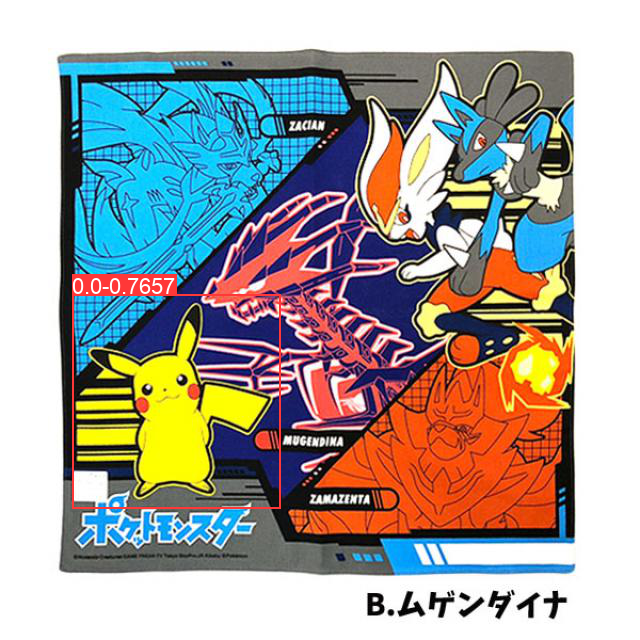

In [83]:
im = Image.open(image_path)
annotator = Annotator(np.ascontiguousarray(im), line_width=2, pil=True)
for result in json.loads(results):
    xyxy = result[:4]
    conf, cls = result[4:]
    annotator.box_label(xyxy, label=f'{cls}-{conf:.4f}', color=colors(int(cls)))
annotator.im.show()